
# Training Artificial Neural Networks with MNIST Dataset


# Introduction
In this tutorial, you will:
* Learn how Artifical neurons are implemented as in a feed-forward neural network.


If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`


In [2]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

Note that the reset mechanism is detached from the computational graph, as the surrogate gradient should only be applied to $\partial S/\partial U$, and not $\partial R/\partial U$.

The above neuron is instantiated using:

In [ ]:
lif1 = LeakySurrogate(beta=0.9)

This neuron can be simulated using a for-loop, just as in previous tutorials, while PyTorch's automatic differentation (autodiff) mechanism keeps track of the gradient in the background.

Alternatively, the same thing can be accomplished by calling the `snn.Leaky` neuron.
In fact, every time you call any neuron model from snnTorch, the *ATan* surrogate gradient is applied to it by default:

In [ ]:
lif1 = snn.Leaky(beta=0.9) #First-order leaky integrate-and-fire neuron model

If you would like to explore how this neuron behaves, then refer to [Tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

#3. Backprop Through Time
Equation $(4)$ only calculates the gradient for one single time step (referred to as the *immediate influence* in the figure below), but the backpropagation through time (BPTT) algorithm calculates the gradient from the loss to *all* descendants and sums them together.

The weight $W$ is applied at every time step, and so imagine a loss is also calculated at every time step. The influence of the weight on present and historical losses must be summed together to define the global gradient:

$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} =
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$

The point of $(5)$ is to ensure causality: by constraining $s\leq t$, we only account for the contribution of immediate and prior influences of $W$ on the loss. A recurrent system constrains the weight to be shared across all steps: $W[0]=W[1] =~... ~ = W$. Therefore, a change in $W[s]$ will have the same effect on all $W$, which implies that $\partial W[s]/\partial W=1$:

$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$

As an example, isolate the prior influence due to $s = t-1$ *only*; this means the backward pass must track back in time by one step. The influence of $W[t-1]$ on the loss can be written as:

$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} =
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{Eq.~(5)}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$

We have already dealt with all of these terms from $(4)$, except for $\partial U[t]/\partial U[t-1]$. From $(1)$, this temporal derivative term simply evaluates to $\beta$. So if we really wanted to, we now know enough to painstakingly calculate the derivative of every weight at every time step by hand, and it'd look something like this for a single neuron:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

But thankfully, PyTorch's autodiff takes care of that in the background for us.  

*Note: The reset mechanism has been omitted from the above figure. In snnTorch, reset is included in the forward-pass, but detached from the backward pass.*


# 4. Setting up the Loss / Output Decoding
In a conventional, non-spiking neural network, a supervised, multi-class classification problem takes the neuron with the highest activation and treats that as the predicted class.

In a spiking neural net, there are several options to interpreting the output spikes. The most common approaches are:
* **Rate coding:** Take the neuron with the highest firing rate (or spike count) as the predicted class
* **Latency coding:** Take the neuron that fires *first* as the predicted class

This might feel familiar to [Tutorial 1 on neural encoding](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). The difference is that, here, we are interpreting (decoding) the output spikes, rather than encoding/converting raw input data into spikes.

Let's focus on a rate code. When input data is passed to the network, we want the correct neuron class to emit the most spikes over the course of the simulation run. This then corresponds to the highest average firing frequency. One way to achieve this is to increase the membrane potential of the correct class to $U>U_{\rm thr}$, and that of incorrect classes to $U<U_{\rm thr}$. Applying the target to $U$ serves as a proxy for modulating spiking behavior from $S$.

This can be implemented by taking the softmax of the membrane potential for output neurons, where $C$ is the number of output classes:

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$

The cross-entropy between $p_i$ and the target $y_i \in \{0,1\}^C$, which is a one-hot target vector, is obtained using:

$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

The practical effect is that the membrane potential of the correct class is encouraged to increase while those of incorrect classes are reduced. In effect, this means the correct class is encouraged to fire at all time steps, while incorrect classes are suppressed at all steps. This may not be the most efficient implementation of an SNN, but it is among the simplest.

This target is applied at every time step of the simulation, thus also generating a loss at every step. These losses are then summed together at the end of the simulation:

$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

This is just one of many possible ways to apply a loss function to a spiking neural network. A variety of approaches are available to use in snnTorch (in the module `snn.functional`), and will be the subject of a future tutorial.

With all of the background theory having been taken care of, let’s finally dive into
training a fully-connected spiking neural net.

# 5. Setting up the Static MNIST Dataset

In [3]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.88MB/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.15MB/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



In [5]:
print('Samples in test set:',len(mnist_test))
print('Samples in train set:',len(mnist_train))

Samples in test set: 10000
Samples in train set: 60000


If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [6]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. Define the Network

In [7]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10


In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.relu2 = nn.ReLU()

    def forward(self, x):

        lin1 = self.fc1(x)
        lin1_act = self.relu1(lin1)
        lin2 = self.fc2(lin1_act)
        lin2_act = self.relu2(lin2)

        return lin2_act

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# 7. Training the ANN

## 7.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [17]:
# # pass data into the network, sum the spikes over time
# # and compare the neuron with the highest number of spikes
# # with the target

# def print_batch_accuracy(data, targets, train=False):
#     output, _ = net(data.view(batch_size, -1))
#     _, idx = output.sum(dim=0).max(1)
#     acc = np.mean((targets == idx).detach().cpu().numpy())

#     if train:
#         print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
#     else:
#         print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

# def train_printer(
#     data, targets, epoch,
#     counter, iter_counter,
#         loss_hist, test_loss_hist, test_data, test_targets):
#     print(f"Epoch {epoch}, Iteration {iter_counter}")
#     print(f"Train Set Loss: {loss_hist[counter]:.2f}")
#     print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
#     print_batch_accuracy(data, targets, train=True)
#     print_batch_accuracy(test_data, test_targets, train=False)
#     print("\n")

In [47]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output = net(data.view(batch_size, -1))
    # _, idx = output.sum(dim=0).max(1)
    pred = np.argmax(output.detach().cpu().numpy(), axis=1)
    acc = np.mean((targets.detach().cpu().numpy() == pred))

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [9]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [44]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [12]:
data.shape

torch.Size([128, 1, 28, 28])

In [14]:
data.view(batch_size, -1).shape

torch.Size([128, 784])

Flatten the input data to a vector of size $784$ and pass it into the network.

In [45]:
# spk_rec, mem_rec = net(data.view(batch_size, -1))
# print(mem_rec.size())
output = net(data.view(batch_size, -1))
print(output.size())

torch.Size([128, 10])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

In [50]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# # sum loss at every step
# for step in range(num_steps):
loss_val = loss(output, targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 2.305


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around 10%) as the network is untrained:

In [48]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 6.25%


A single weight update is applied to the network as follows:

In [51]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [52]:
# calculate new network outputs using the same data
output = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
loss_val = loss(output, targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 2.231
Train set accuracy for a single minibatch: 39.84%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy
loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [53]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        output = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        # for step in range(num_steps):
            # loss_val += loss(mem_rec[step], targets)
        loss_val = loss(output, targets)


        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            output = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            # for step in range(num_steps):
                # test_loss += loss(test_mem[step], test_targets)
            test_loss = loss(output, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 2.27
Test Set Loss: 2.21
Train set accuracy for a single minibatch: 42.19%
Test set accuracy for a single minibatch: 38.28%


Epoch 0, Iteration 50
Train Set Loss: 0.96
Test Set Loss: 0.73
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 78.12%


Epoch 0, Iteration 100
Train Set Loss: 0.74
Test Set Loss: 0.77
Train set accuracy for a single minibatch: 73.44%
Test set accuracy for a single minibatch: 71.09%


Epoch 0, Iteration 150
Train Set Loss: 0.52
Test Set Loss: 0.86
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 69.53%


Epoch 0, Iteration 200
Train Set Loss: 0.77
Test Set Loss: 0.78
Train set accuracy for a single minibatch: 74.22%
Test set accuracy for a single minibatch: 71.88%


Epoch 0, Iteration 250
Train Set Loss: 0.53
Test Set Loss: 0.60
Train set accuracy for a single minibatch: 82.03%
Test set accuracy for a single minibatch: 78.91%


Epoch 0, Iter

If this was your first time training an ANN, then congratulations!

# 8. Results
## 8.1 Plot Training/Test Loss

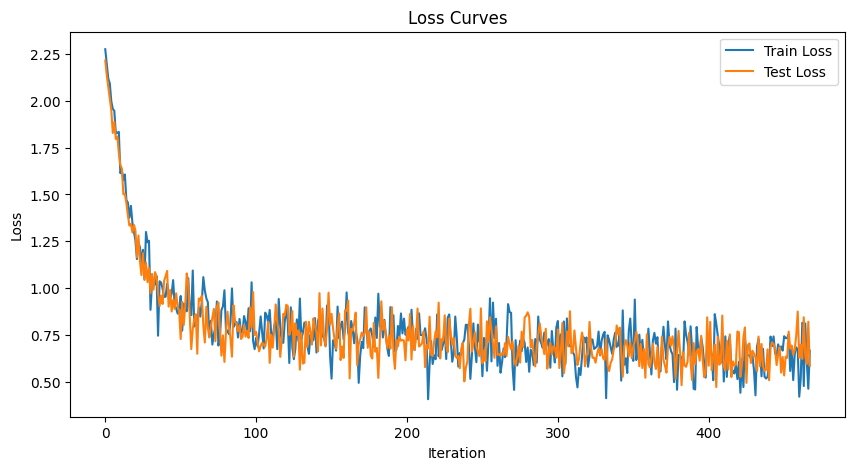

In [54]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [61]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# output = net(data.view(batch_size, -1))
# _, idx = output.sum(dim=0).max(1)
# pred = np.argmax(output.detach().cpu().numpy(), axis=1)
# acc = np.mean((targets.detach().cpu().numpy() == pred))


with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    output = net(data.view(data.size(0), -1))
    pred = np.argmax(output.detach().cpu().numpy(), axis=1)
    acc = np.sum((targets.detach().cpu().numpy() == pred))

    # calculate total accuracy
    # _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += acc

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 7593/10000
Test Set Accuracy: 75.93%


In [60]:
print(pred)
print(targets.detach().cpu().numpy())

[4 8 2 8 2 8 0 4 7 4 9 0 0 7 3 4]
[4 8 2 8 2 8 1 9 7 5 9 1 0 1 3 4]


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance.

# Additional Resources



* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)

This Implementation is based on below referenced paper.

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>